# Predicting Sale Prices for Homes in Ames, IA
## Multiple Linear Regression Model

## Problem Statement

Given the Ames Housing Dataset, this project aims to create a linear regression model that will predict the sale price of a home. The data was collected from 2051 houses sold in Ames, IA between the years 2006 and 2010, with a total of 82 descriptive features. The goal is to create a predictive model better than a baseline estimate by employing feature engineering, various regularization methods, and cross-validation techniques. 


## Executive Summary

After cross-validation, we determine the lasso method of linear regression modeling gives us the highest, most consistent R^2 score. Our final model considers 201 of our selected features to be strong predictors and accounts for 92% of variability in our target variable, Sale Price. This model can be used to predict the approximate sale price for homes sold in Ames, IA, with certain limitations. 

## Contents:  
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.pipeline import Pipeline

sns.set_style('ticks')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Import & Cleaning

In [2]:
df = pd.read_csv('../data/train.csv')
# format column names
df.columns = [i.lower().replace(' ','_') for i in df.columns]
df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
nulls = df.isnull().sum()
for i,n in enumerate(nulls):
    print(df.columns[i],n)

id 0
pid 0
ms_subclass 0
ms_zoning 0
lot_frontage 330
lot_area 0
street 0
alley 1911
lot_shape 0
land_contour 0
utilities 0
lot_config 0
land_slope 0
neighborhood 0
condition_1 0
condition_2 0
bldg_type 0
house_style 0
overall_qual 0
overall_cond 0
year_built 0
year_remod/add 0
roof_style 0
roof_matl 0
exterior_1st 0
exterior_2nd 0
mas_vnr_type 22
mas_vnr_area 22
exter_qual 0
exter_cond 0
foundation 0
bsmt_qual 55
bsmt_cond 55
bsmt_exposure 58
bsmtfin_type_1 55
bsmtfin_sf_1 1
bsmtfin_type_2 56
bsmtfin_sf_2 1
bsmt_unf_sf 1
total_bsmt_sf 1
heating 0
heating_qc 0
central_air 0
electrical 0
1st_flr_sf 0
2nd_flr_sf 0
low_qual_fin_sf 0
gr_liv_area 0
bsmt_full_bath 2
bsmt_half_bath 2
full_bath 0
half_bath 0
bedroom_abvgr 0
kitchen_abvgr 0
kitchen_qual 0
totrms_abvgrd 0
functional 0
fireplaces 0
fireplace_qu 1000
garage_type 113
garage_yr_blt 114
garage_finish 114
garage_cars 1
garage_area 1
garage_qual 114
garage_cond 114
paved_drive 0
wood_deck_sf 0
open_porch_sf 0
enclosed_porch 0
3ssn_porc

 - Our dataframe has null values, however, according to the [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we know these null values offer some information. We can  fill in 0 for numeric columns and leave None as a string in categorical features where they are applicable.  
 - Also, we will change 'MS Subclass', which is a nominal category disguised as an integer type, and binarize 'Central Air' to 1 if Yes, and 0 if No.  
 - For features that describe a quality or condition of the home, we will convert those to a scaled number from 1-5, or 0 if it that feature doesn't exist/apply. 

In [4]:
#change ms_subclass to object type
df['ms_subclass'] = df['ms_subclass'].astype(str)

#change central_air column to 1's and 0's
df['central_air'] = df['central_air'].map({'Y':1,'N':0})

#create dict and list to change 'quality' and 'condition' features on a scale from 1-5, 0 if n/a
qc_dict={'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1,'NA' : 0, None : 0}
qc_features = ['exter_qual','exter_cond','bsmt_qual',
              'bsmt_cond','heating_qc', 'kitchen_qual',
              'fireplace_qu','garage_qual','garage_cond','pool_qc']
for col in qc_features:
    df[col] = df[col].map(qc_dict,na_action = 'ignore')

#correct for extraneous characters in ms_zoning column
ms_zoning_dict = {'RL' : 'RL','RM' : 'RM','FV' : 'FV','C (all)' : 'C','RH' : 'RH','A (agr)' : 'A','I (all)' : 'I'}
df['ms_zoning'] = df['ms_zoning'].map(ms_zoning_dict, na_action = 'ignore')

#fill numeric NaN with 0
numeric_columns = df._get_numeric_data().columns
df[numeric_columns] = df[numeric_columns].fillna(0)

#fill remaining NaN with string 'None'
df = df.fillna('None')

In [5]:
#there is an erroneous entry in the garage_year_built as 2207
df[df['garage_yr_blt'] > 2010][['garage_yr_blt','year_remod/add','year_built']]

,garage_yr_blt,year_remod/add,year_built
1699,2207.0,2007,2006


In [6]:
#referencing this observation's year_remod/add & year_built columns, we will impute a corrected value of 2007
df.loc[df[df['garage_yr_blt'] == 2207].index, 'garage_yr_blt'] = 2007

In [7]:
#In most cases, if the property does not have a garage ("None"), the garage_yr_built was filled in with 0
#except in this case below, where the garage_type is "Detached", yet is missing data for which year it was built.
df[(df['garage_yr_blt'] == 0) != (df['garage_type'] == 'None')][['garage_yr_blt','garage_type']]

,garage_yr_blt,garage_type
1712,0.0,Detchd


With 2051 observations and 78 descriptive features (excluding target, ID, & PID), the Ames Housing Data is pretty thorough and should provide plenty of features for us to create a working linear regression model. However, there are some features that, even after cleaning, we may decide to exclude from our final model:
 - The 'garage year built' column is problematic as there are 0's representing the value of a year. More telling features to focus on would be the 'garage type' and the year the house was remodeled or built. 

# Exploratory Data Analysis

Our target variable is the Sale Price of a home. We will look at its distribution, and explore features that may affect its outcome:

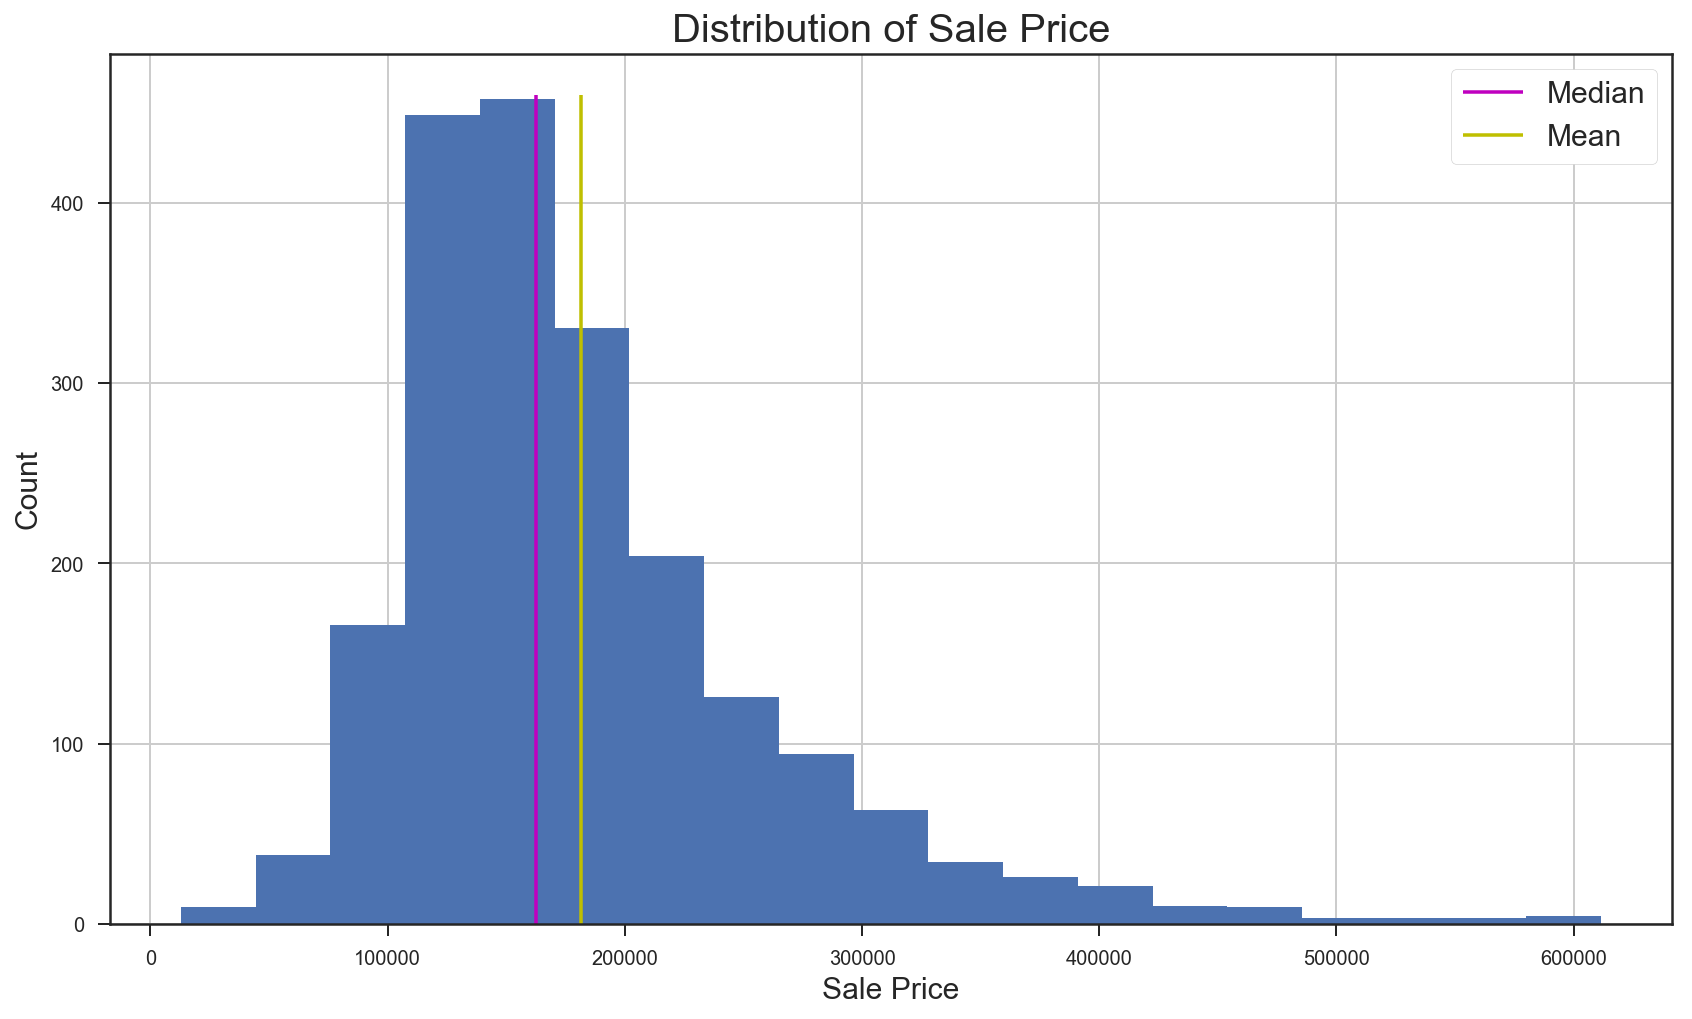

In [8]:
#plot distribution of sale price
plt.figure(figsize = (14,8))
df['saleprice'].hist(bins=19);
#add line to indicate median
plt.vlines(x=(df['saleprice'].median()),ymin=0,ymax=460,colors=['m'],label='Median')
#add line to indicate mean
plt.vlines(x=(df['saleprice'].mean()),ymin=0,ymax=460,colors=['y'],label='Mean')
plt.title("Distribution of Sale Price",fontsize = 20)
plt.xlabel("Sale Price", fontsize = 15)
plt.ylabel("Count",fontsize = 15)
plt.legend(prop={'size': 15},framealpha=1, frameon=True, facecolor= 'white');

In [9]:
pd.DataFrame(df.saleprice.describe())

,saleprice
count,2051.000000
mean,181469.701609
std,79258.659352
min,12789.000000
25%,129825.000000
50%,162500.000000
75%,214000.000000
max,611657.000000


 - The distribution of our target variable is right skewed: There are fewer homes that were sold at relatively high prices. However, the mean and median remain somewhat close to its mode. 
 - Observed Sale Prices fall between \\\$12,789 and \\$39,2500, with an average of \$15,5864.42.

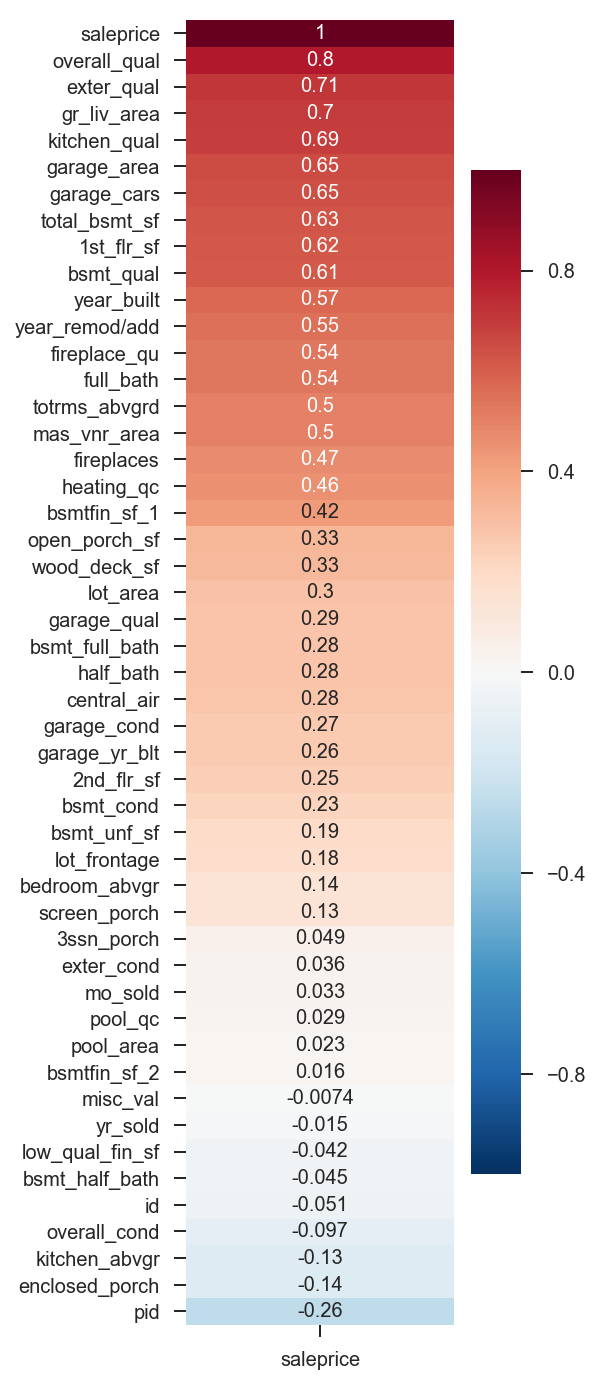

In [10]:
#heatmap of saleprice correlations to all numerical columns,
plt.figure(figsize = (3,12))
sns.heatmap(df.corr()[['saleprice']].sort_values('saleprice', ascending = False),annot=True);

 - The overall quality of a home is the most positively correlated feature to its sale price; i.e. the better overall  quality, the higher the sale price.  
 - We also observe that the more square footage and parking availability a home has, the higher the sale price is expected to be. Furthermore, it appears that newer built homes and newly renovated homes have higher sale prices.  
 - ID and PID are arbitrated, essentially random, features that should have little to no correlation to the sale price of a home. There is also low correlation between when (year/month) the home was sold, to its sale price.
 - Surprisingly, the overall condition of a home is negatively (albeit minimally) correlated to its sale price. Perhaps buyers are more concerned with a homes' potential, rather than its current condition. 

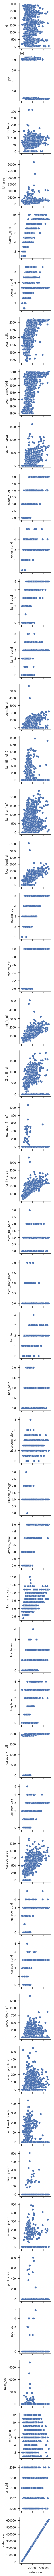

In [11]:
# pairplot to explore linearity
sns.pairplot(df[numeric_columns], y_vars=numeric_columns, x_vars=['saleprice'])

**Below are some scatterplots and boxplots of features that may impact our model:**

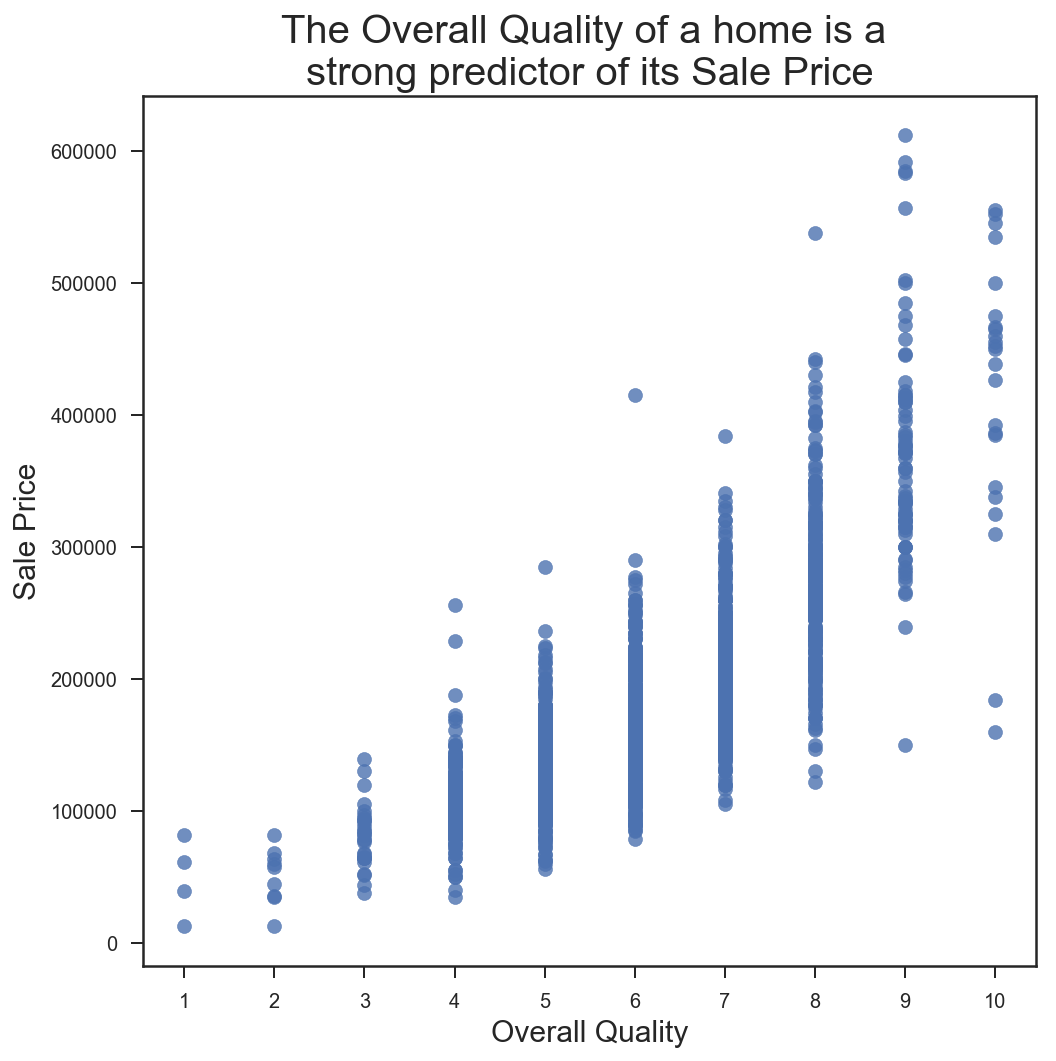

In [12]:
#scatterplot of overall quality vs. saleprice
plt.figure(figsize = (8,8))
plt.scatter(df['overall_qual'],df['saleprice'], alpha=0.8)
plt.xlabel("Overall Quality", fontsize = 15)
plt.xticks(ticks = list(range(1,11)))
plt.ylabel("Sale Price", fontsize = 15)
plt.title("The Overall Quality of a home is a \nstrong predictor of its Sale Price",fontsize=20);

 - The overall quality of a home is graded on a scale from 1 to 10. 
 - As Overall Quality increases, we observe a general increase in Sale Price. 
 - There is a 0.80 linear correlation coefficient.

/Users/tofer/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


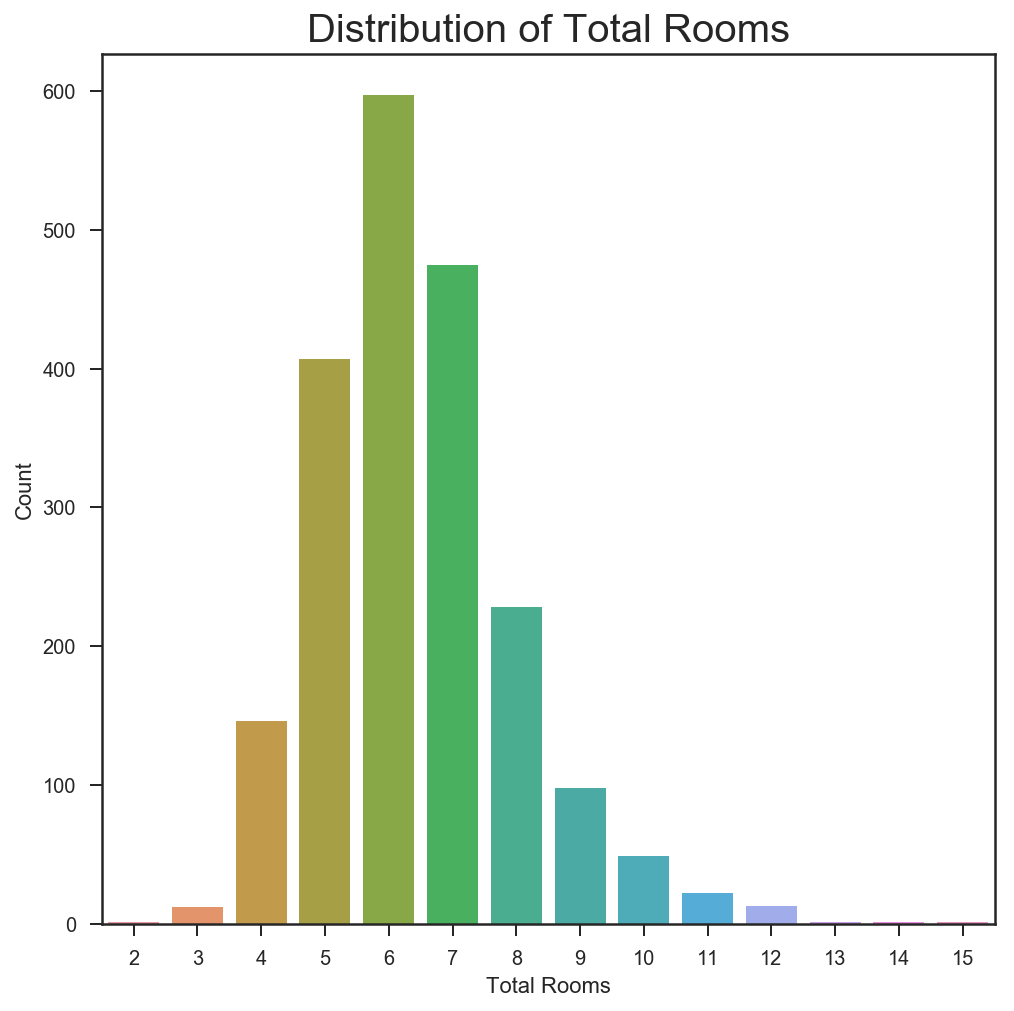

In [13]:
#plots distribution of total rooms
plt.figure(figsize = (8,8))
sns.countplot(x='totrms_abvgrd', data = df)
plt.title("Distribution of Total Rooms", fontsize = 20)
plt.xlabel("Total Rooms")
plt.ylabel("Count");

In [14]:
pd.DataFrame(df.totrms_abvgrd.describe()).T

,count,mean,std,min,25%,50%,75%,max
totrms_abvgrd,2051.0,6.435885,1.560225,2.0,5.0,6.0,7.0,15.0


 - There is a somewhat normal distribution of total rooms, with the mean and median close to the mode ~6.

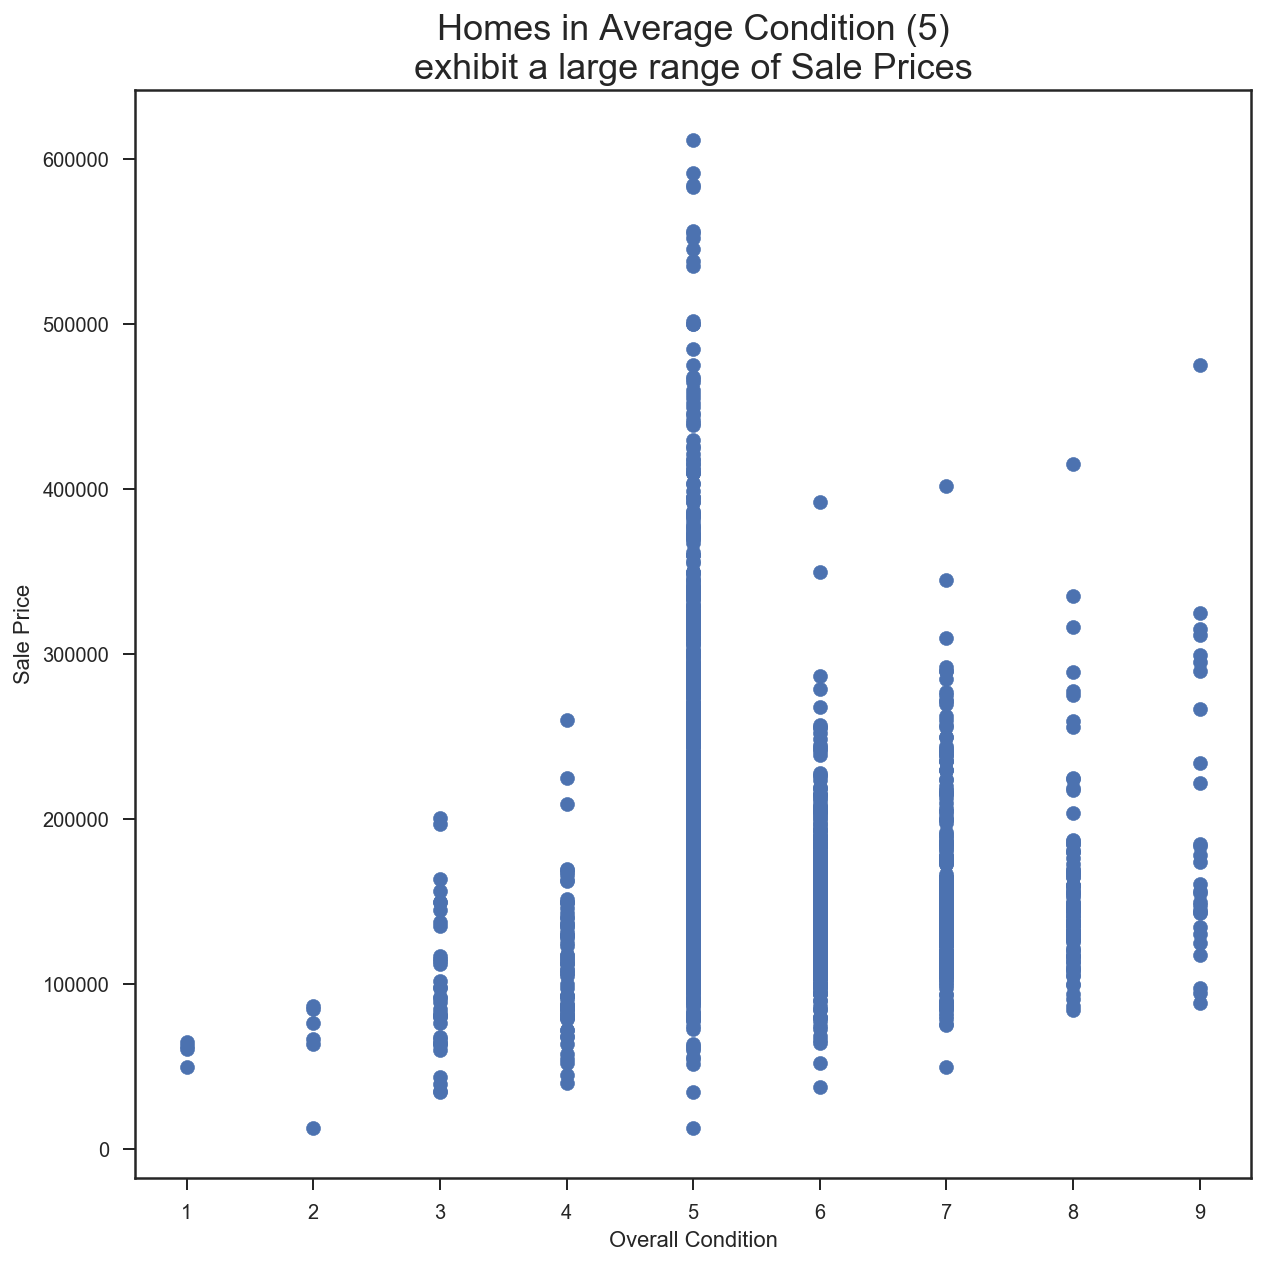

In [15]:
#scatterplot of overall condition vs. saleprice
plt.figure(figsize = (10,10))
plt.scatter(df['overall_cond'], df['saleprice'])
plt.xlabel("Overall Condition")
plt.ylabel("Sale Price")
plt.title("Homes in Average Condition (5)\nexhibit a large range of Sale Prices",fontsize=18);

 - Homes in the best condition have higher prices than those in poor condition, however, there is a low linear correlation due to the range of sale prices of homes in average condition. 

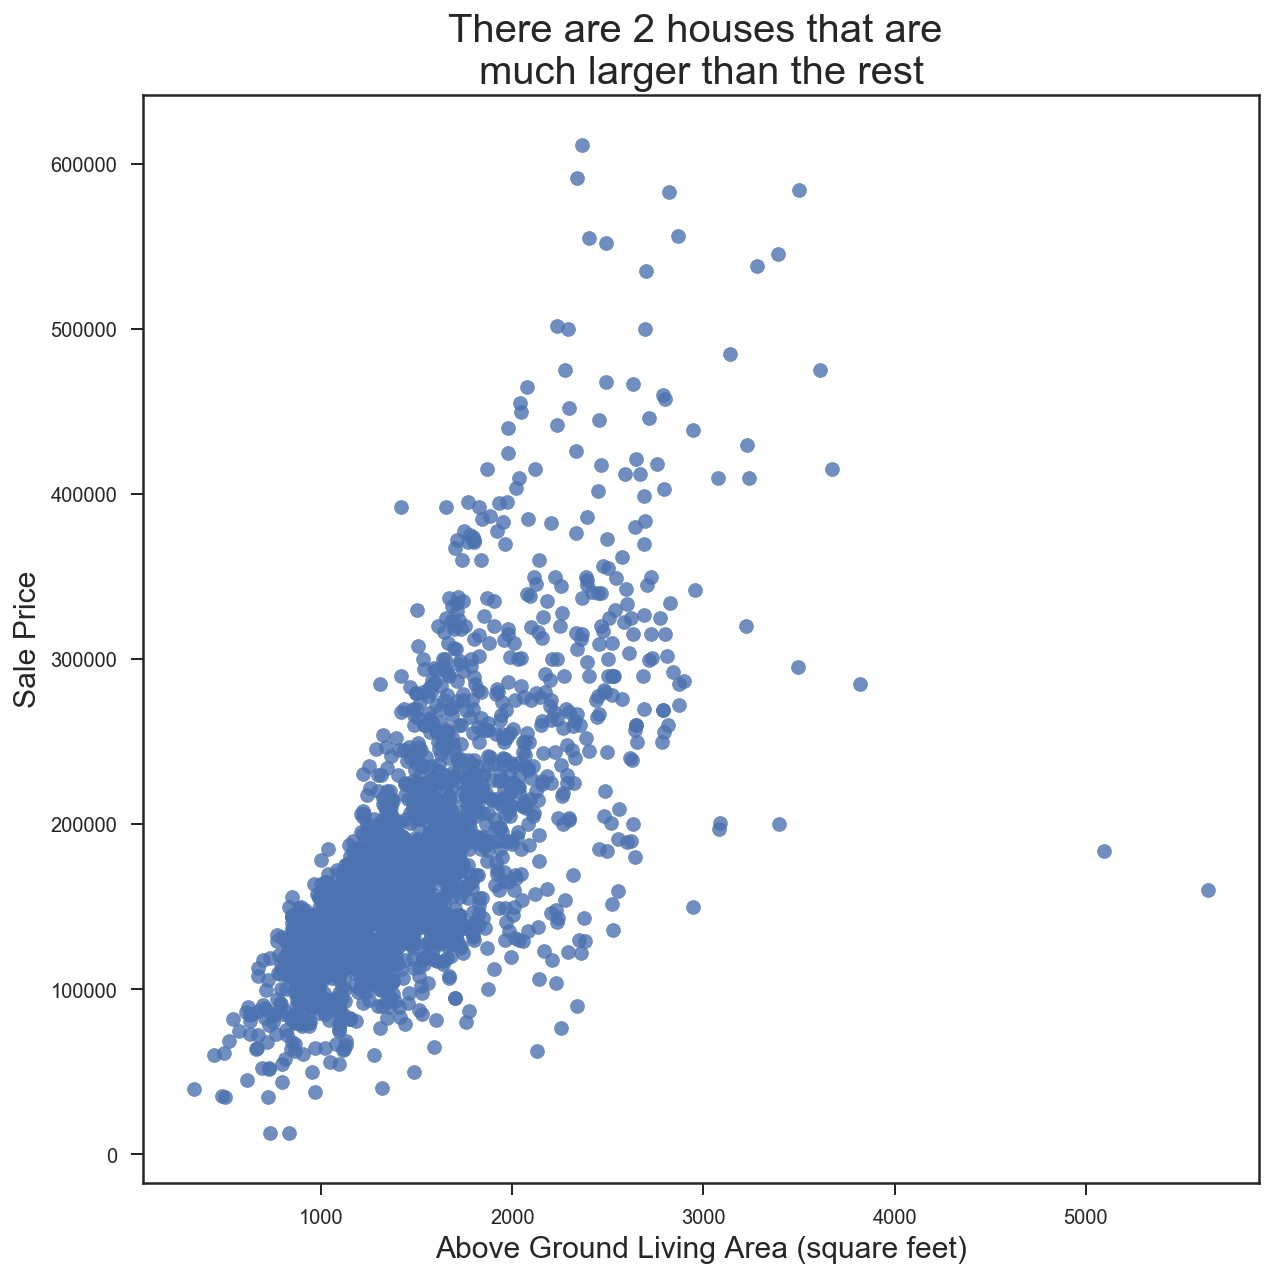

In [16]:
#scatterplot of above grade living area vs. saleprice
plt.figure(figsize = (10,10))
plt.scatter(df['gr_liv_area'], df['saleprice'],alpha=.8)
plt.xlabel("Above Ground Living Area (square feet)", fontsize = 15)
plt.ylabel("Sale Price", fontsize = 15)
plt.title("There are 2 houses that are \nmuch larger than the rest", fontsize=20);

 - Above ground square footage is typically a good indicator for the sale price of a home (also evidenced by our correlation heat map). 
 - The smallest observed home is only 334 sq ft.
 - There are two outliers with very large square footage (>4000), but with sale prices close to the mean and median, which may cause our model to undershoot the sale price of larger homes in our final predictions. The next largest home has 2,814 square feet of living area. 
 - We will remove these two outliers from our dataset.

In [17]:
#display count of roof material values
pd.DataFrame(df['roof_matl'].value_counts())

,roof_matl
CompShg,2025
Tar&Grv,15
WdShngl,5
WdShake,4
Membran,1
ClyTile,1


 - Composition Shingles is by far the most popular roof material. There are some observations that only account for 1 or few observations. This could affect our model by not providing enough complete data for these types of roof materials.

In [18]:
#display count of misc. feature values
pd.DataFrame(pd.value_counts(df['misc_feature']))

,misc_feature
None,1986
Shed,56
Gar2,4
Othr,3
Elev,1
TenC,1


 - Similarly, for Miscellaneous Features, we see there is only one home with an elevator and one home with a Tennis Court. There is another column "Miscellaneous Value" which may be more valuable to our model as it may have more of a direct impact on the sale price. 

In [ ]:
pd.DataFrame(df.kitchen_abvgr.value_counts())

,kitchen_abvgr
1,1960
2,88
0,2
3,1


 - We will remove Total Kitchens Above Ground outliers as well.

In [ ]:
#create dataframe of neighborhoods and rank them by each neighborhoods' average sale price, from lowest to highest
#adapted from Ritchie's code
neighborhood_ranks = pd.DataFrame(df.groupby(['neighborhood'])['saleprice'].mean())
neighborhood_ranks.sort_values('saleprice',ascending=True,inplace=True)
neighborhood_ranks['rank'] = list(range(1,neighborhood_ranks.shape[0]+1))

#replace their value in our dataframe with its numerical ranking
neighborhood_dict = neighborhood_ranks['rank'].to_dict()
df['neighborhood'].replace(neighborhood_dict, inplace = True)

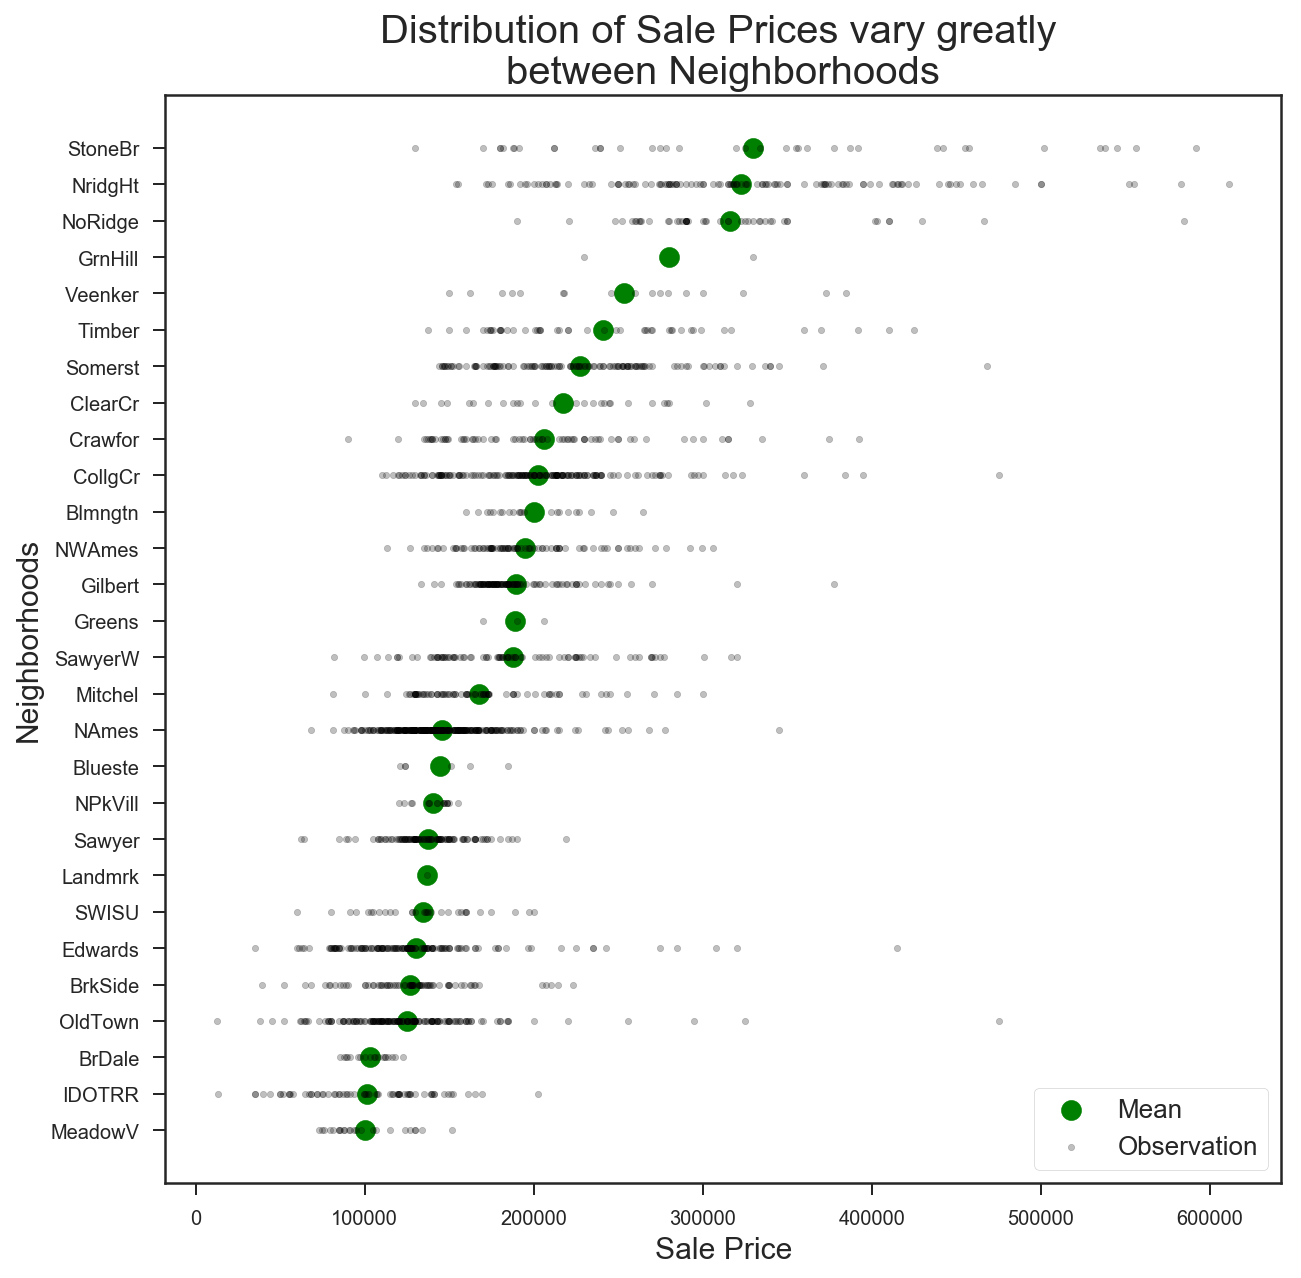

In [ ]:
plt.figure(figsize = (10,10))
#plot average sale price of each neighborhood
plt.scatter(neighborhood_ranks['saleprice'],neighborhood_ranks.index,s=100,c='g',label='Mean')
#plot sale price of all observations, by each of neighborhood
plt.scatter(df['saleprice'],df['neighborhood']-1,s=10,c='k',alpha=.25,label='Observation')
plt.xlabel("Sale Price", fontsize = 15)
plt.ylabel("Neighborhoods", fontsize = 15)
plt.title("Distribution of Sale Prices vary greatly \nbetween Neighborhoods",fontsize=20)
plt.legend(prop={'size': 13},framealpha=1, frameon=True, facecolor= 'white',loc = 'lower right');

 - The average sale price changes between neighborhoods, from around 100,000 to almost 330,000. This tells us that the neighborhood in which the home resides can have a great impact on its sale price. 
 - We changed the values in the neighborhood column to reflect a numerical ranking in order to apply polynomial features and explore interactions with other pertinent features.
 - Unfortunately, this transformation limits our ability to directly interpret how the homes' neighborhood affects the sale price. Instead, we are left with a ranking relative to the other neighborhoods in Ames. We must also caution that ranking the neighborhoods based on averages of the target variable may lead to data leakage in our model.

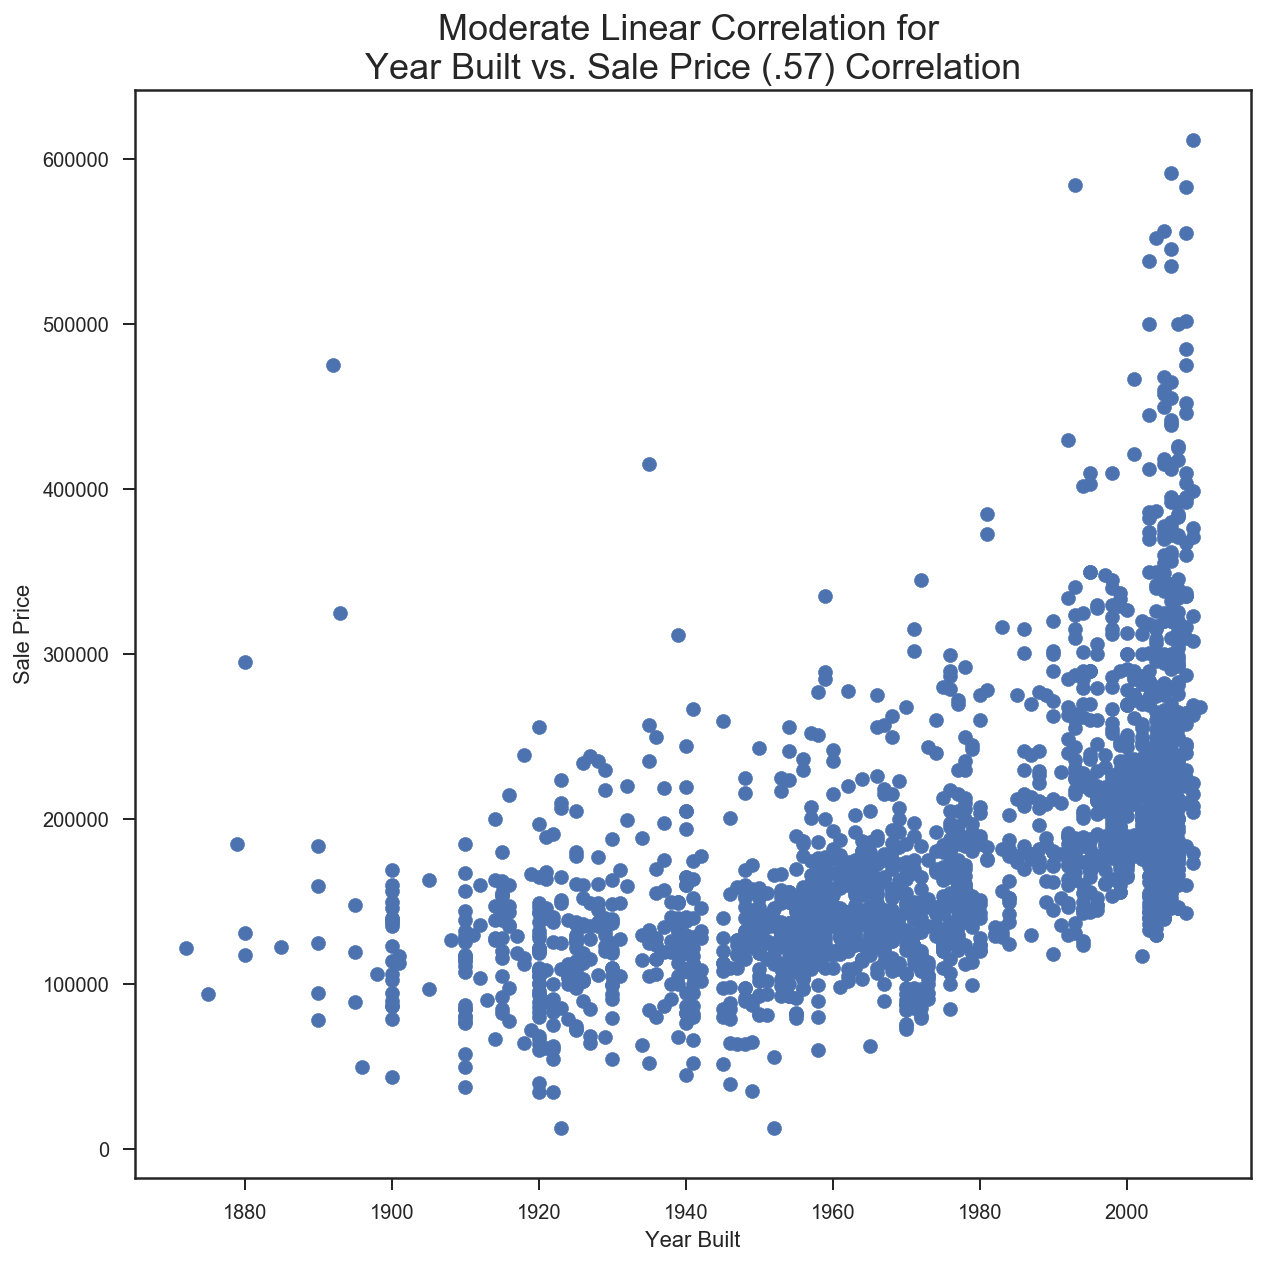

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(df['year_built'],df['saleprice'])
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.title("Moderate Linear Correlation for \nYear Built vs. Sale Price (.57) Correlation",fontsize=18);

 - Generally, newer built homes sell at a higher price. There is a moderate linear correlation.

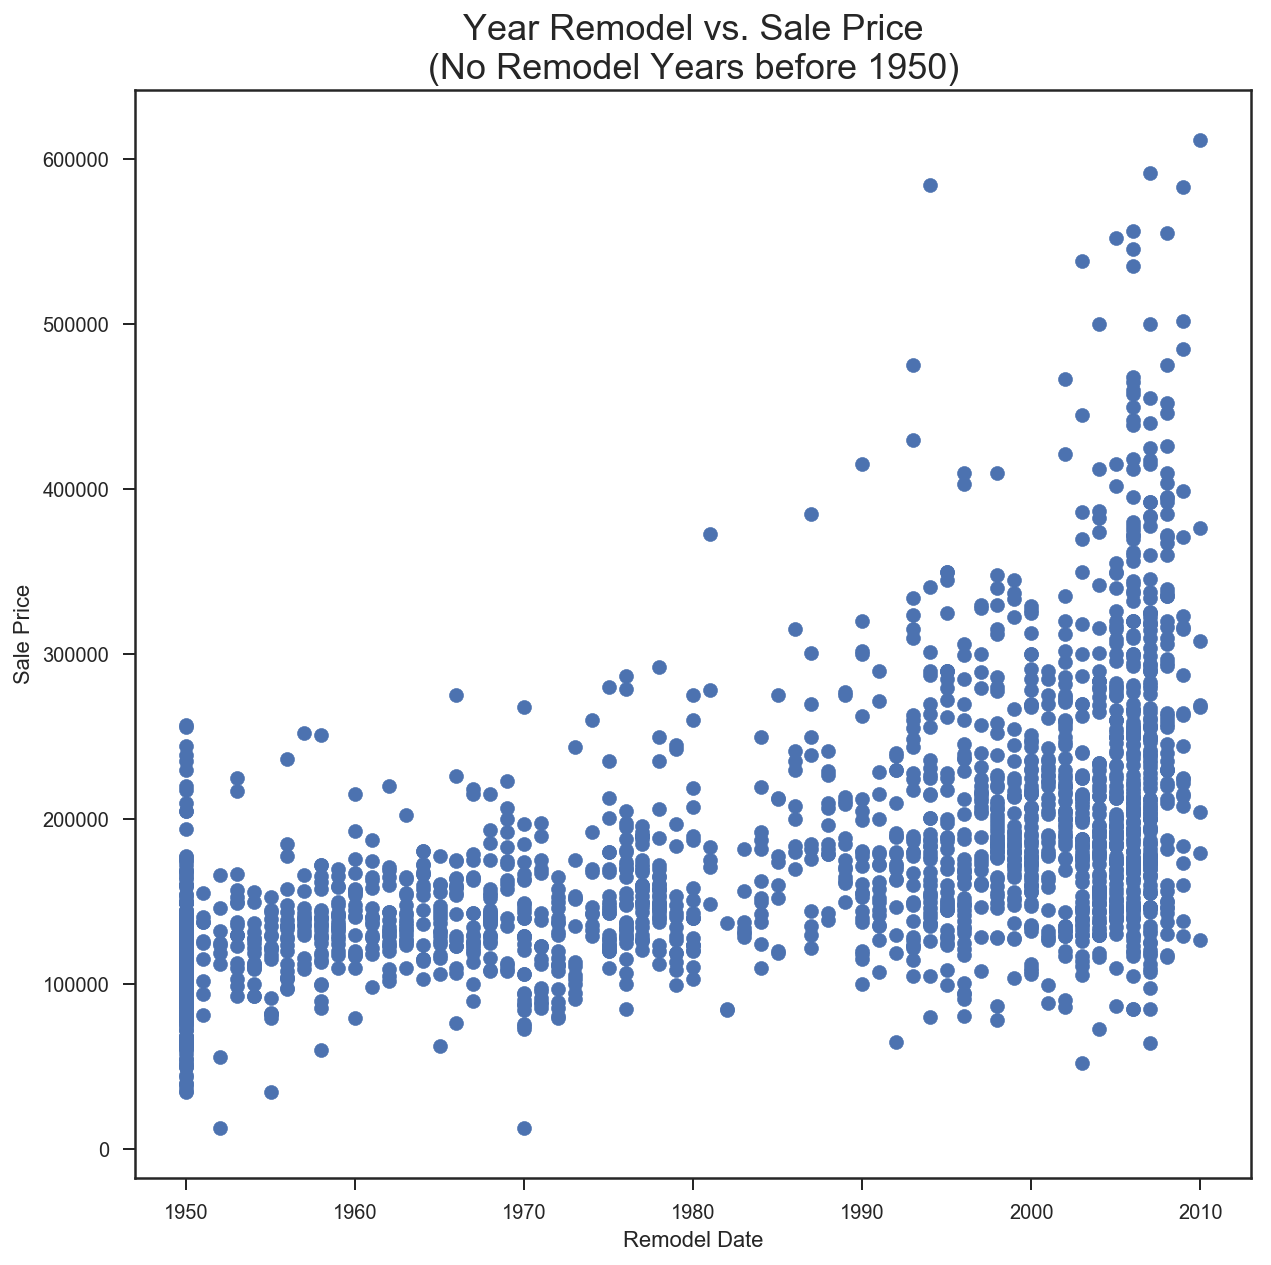

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(df['year_remod/add'],df['saleprice'])
plt.xlabel("Remodel Date")
plt.ylabel("Sale Price")
plt.title("Year Remodel vs. Sale Price\n(No Remodel Years before 1950)",fontsize=18);

- An issue arises in our Year Remodel column: If the house was never remodeled, or if the house was remodeled before 1950, it appears a value of 1950 was designated as the default. 
- We will create a binary column indicating whether the house was remodeled in or before the year 1950.

In [ ]:
#create column indicating whether the house was built in or before 1950
df['remodel_1950'] = df['year_remod/add'].apply(lambda x: 1 if x == 1950 else 0)

**Removing outliers:**

In [ ]:
#remove very large sqft outliers
df = df[df['gr_liv_area'] < 4000]

#remove roof_matl outliers ('ClayTile' was already removed)
df = df.drop(index = df[df['roof_matl'] == 'Membran'].index, axis = 0)

#remove misc_feature outliers ('Elevator' was already removed)
df = df.drop(index = df[df['misc_feature'] == 'TenC'].index, axis = 0)

#remove kitchens_abvgr outliers (0 and 3)
df = df.drop(index = df[(df['kitchen_abvgr'] == 0) | (df['kitchen_abvgr'] == 3)].index, axis = 0)

#reset index
df.reset_index(drop='index',inplace=True)

## Preprocessing and Modeling

Now that our data is clean, we can engineer polynomial features on select variables and create dummy variable columns for our categorical features:

### Feature Engineering

### Get Dummies

In [ ]:
kbest = SelectKBest(f_regression,k=15)

In [ ]:
#create dummy columns on remaining categorical features. 
#avoid one-hot encoding in order to remain consistent with kaggle test data columns
df_dummies = pd.get_dummies(df)

In [ ]:
df_dummies.columns

Index(['id', 'pid', 'lot_frontage', 'lot_area', 'neighborhood', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       ...
       'misc_feature_Shed', 'sale_type_COD', 'sale_type_CWD', 'sale_type_Con',
       'sale_type_ConLD', 'sale_type_ConLI', 'sale_type_ConLw',
       'sale_type_New', 'sale_type_Oth', 'sale_type_WD '],
      dtype='object', length=247)

In [ ]:
#instatiate polynomial features
poly = PolynomialFeatures(include_bias=False, interaction_only=True)

poly_features = [col for col in df_dummies.columns if col not in ['id','pid','saleprice','garage_yr_blt',]]
poly.fit(df_dummies[poly_features])
df_poly_dummies = pd.DataFrame(poly.transform(df_dummies[poly_features]),
                               columns=poly.get_feature_names(poly_features))

# # #drop original poly features columns for concatenation to training dataframe
# df_poly_dummies = df_dummies.drop(poly_features,axis=1)
# df_poly_dummies = pd.concat([df_dummies,df_poly_dummies],axis =1)

In [ ]:
features = [col for col in df_poly_dummies.columns if col not in ['id','pid','saleprice','garage_yr_blt',]]
X = df_poly_dummies[features]
y = df['saleprice']

In [ ]:
X_kbest = kbest.fit_transform(X,y)

/Users/tofer/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/tofer/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tofer/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tofer/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [ ]:
mask = kbest.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, features):
    if bool:
        new_features.append(feature)


In [ ]:
pd.DataFrame(X_kbest,columns=new_features)

,neighborhood overall_qual,neighborhood total_bsmt_sf,neighborhood 1st_flr_sf,neighborhood gr_liv_area,overall_qual exter_qual,overall_qual total_bsmt_sf,overall_qual 1st_flr_sf,overall_qual gr_liv_area,overall_qual kitchen_qual,overall_qual garage_cars,overall_qual garage_area,exter_qual gr_liv_area,bsmt_qual gr_liv_area,total_bsmt_sf gr_liv_area,gr_liv_area kitchen_qual
0,54.0,6525.0,6525.0,13311.0,24.0,4350.0,4350.0,8874.0,24.0,12.0,2850.0,5916.0,4437.0,1072275.0,5916.0
1,98.0,12782.0,12782.0,29708.0,28.0,6391.0,6391.0,14854.0,28.0,14.0,3913.0,8488.0,8488.0,1937386.0,8488.0
2,60.0,12684.0,12684.0,12684.0,15.0,5285.0,5285.0,5285.0,20.0,5.0,1230.0,3171.0,3171.0,1117249.0,4228.0
3,115.0,8832.0,17112.0,33212.0,15.0,1920.0,3720.0,7220.0,15.0,10.0,2000.0,4332.0,5776.0,554496.0,4332.0
4,84.0,9464.0,11634.0,20230.0,18.0,4056.0,4986.0,8670.0,18.0,12.0,2904.0,4335.0,2890.0,976820.0,4335.0
5,72.0,18204.0,22656.0,22656.0,24.0,9102.0,11328.0,11328.0,24.0,12.0,3468.0,7552.0,5664.0,2864096.0,7552.0
6,36.0,3282.0,6432.0,6432.0,18.0,3282.0,6432.0,6432.0,18.0,12.0,3150.0,3216.0,4288.0,586384.0,3216.0
7,60.0,14256.0,14256.0,14256.0,15.0,5940.0,5940.0,5940.0,15.0,10.0,2655.0,3564.0,3564.0,1411344.0,3564.0
8,20.0,3696.0,3696.0,3696.0,15.0,4620.0,4620.0,4620.0,15.0,5.0,2100.0,2772.0,2772.0,853776.0,2772.0
9,60.0,12480.0,12480.0,24960.0,15.0,5200.0,5200.0,10400.0,10.0,10.0,2520.0,6240.0,8320.0,2163200.0,4160.0


### Polynomial Features

In [ ]:
df_poly_dummies.columns

Index(['lot_frontage', 'lot_area', 'neighborhood', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'exter_qual', 'exter_cond',
       ...
       'sale_type_ConLI sale_type_ConLw', 'sale_type_ConLI sale_type_New',
       'sale_type_ConLI sale_type_Oth', 'sale_type_ConLI sale_type_WD ',
       'sale_type_ConLw sale_type_New', 'sale_type_ConLw sale_type_Oth',
       'sale_type_ConLw sale_type_WD ', 'sale_type_New sale_type_Oth',
       'sale_type_New sale_type_WD ', 'sale_type_Oth sale_type_WD '],
      dtype='object', length=29646)

In [ ]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 36)
kf = KFold(n_splits=10, random_state=42, shuffle=True)

### Feature Selection

### K-Fold Cross Validation

In [ ]:
#regularize our data for regression methods
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
#instatiate our models
lr = LinearRegression()
lasso = LassoCV(max_iter=5000)
ridge = RidgeCV()
en = ElasticNetCV(max_iter=5000, l1_ratio=[.1, .5, .7, .9, .95, .99,1])

### Linear Regression Model

In [ ]:
lr.fit(X_train_sc,y_train)
print('Train Score:', lr.score(X_train_sc,y_train))
print('Test Score:', lr.score(X_test_sc, y_test))
print('CV Mean Score:', cross_val_score(lr,X_train_sc,y_train,cv=kf).mean())

Train Score: 1.0
Test Score: 0.6919595670549248
CV Mean Score: 0.7228693588022923


 - A basic multiple linear regression is the first model we fit and score. The model scores well on the training data, however miserably fails to predict sale prices on the test data. This model severely overfits and exhibits extreme variance. The average R^2 score is extremely low because this method weights all of our (now) 309 features equally. 
 - A better prediction would be the baseline: the overall average sale price. 

### Lasso Method

In [ ]:
lasso.fit(X_train_sc,y_train)
print('Train Score:', lasso.score(X_train_sc,y_train))
print('Test Score:', lasso.score(X_test_sc, y_test))
print('CV Mean Score:', cross_val_score(lasso,X_train_sc,y_train,cv=kf).mean())

 - The Lasso method appears to be a promising model. The training score is higher than the testing score but the cross-validated R^2 score falls in between both. This model is doing a decent job of not overfitting or underfitting the testing data 
 - The model exhibits low variance. 

In [ ]:
#calculate residuals
plt.hist(y_train - lasso.predict(X_train_sc), bins = 13)
plt.title("Distribution of Residuals", fontsize = 18);

 - A normal distribution of residuals, centered around zero

In [ ]:
#outputs top 10 features and their coefficients, sorted by absolute value of coefficients
#code adapted from Sunny and Brandon
lasso_coef_df = pd.DataFrame(lasso.coef_, columns=['coefs'])
lasso_coef_df['abs_coefs'] = abs(lasso.coef_)
lasso_coef_df.index = X[features].columns
lasso_coef_df = lasso_coef_df.sort_values('abs_coefs', ascending=False)
lasso_coef_df.head(10)

In [ ]:
print(lasso_coef_df[lasso_coef_df['coefs'] == 0 ].shape[0], "removed features")
print(lasso_coef_df[lasso_coef_df['coefs'] != 0 ].shape[0], "features kept")

 - The most prominent feature in this model is the interaction between Kitchen Quality and Total Above Ground Living Area: If your home is big and has a nice kitchen, it significantly raises the predicted sale price. 
 - The next highest feature is the interaction of Neighborhood with Total Above Ground Living Area: If your big home with the nice kitchen is also in a relatively expensive neighborhood, expect its value to greatly increase. 
 - We also note that Overall Quality and Garage Area remain strong predictors, as we expected from our correlation heatmap. 
 - The Lasso Method retains 93 features and 'zeroed-out' 216 features that were deemed not important to the model. 

### Ridge Method

In [ ]:
ridge.fit(X_train_sc,y_train)
print('Train Score:', ridge.score(X_train_sc,y_train))
print('Test Score:', ridge.score(X_test_sc, y_test))
print('CV Mean Score:', cross_val_score(ridge,X_train_sc,y_train,cv=kf).mean())

 - The Ridge Method also gives a higher R^2 score on the train data than on the R^2 test data. 
 - This may indicates overfitting and high variance.
 - The cross-validated score is lower than both train and test scores, and slightly lower than the Lasso Method. 

In [ ]:
ridge_coef_df = pd.DataFrame(ridge.coef_, columns=['coefs'])
ridge_coef_df['abs_coefs'] = abs(ridge.coef_)
ridge_coef_df.index = X[features].columns
ridge_coef_df = ridge_coef_df.sort_values('abs_coefs', ascending=False)
ridge_coef_df.head(5)

In [ ]:
print(ridge_coef_df[ridge_coef_df['coefs'] == 0 ].shape[0], "features removed")
print(ridge_coef_df[ridge_coef_df['coefs'] != 0 ].shape[0], "features kept")

- The Ridge Method still considers most of the features we've assigned to our model as predictors of the target.
- We note that kitchen quality and basement quality are negatively impacting the sale price, which seems counterintuitive for interpretation purposes.

### Elastic Net Method
The tie-breaker?

In [ ]:
en.fit(X_train_sc,y_train)
print('Train Score:', en.score(X_train_sc,y_train))
print('Test Score:', en.score(X_test_sc, y_test))
print('CV Mean Score:', cross_val_score(en,X_train_sc,y_train,cv=kf).mean())
print("L1 Ratio:", en.l1_ratio_)

In [ ]:
# outputs the same coefficients as Lasso Method, Commented out to eliminate redundancy
# en_coef_df = pd.DataFrame(en.coef_, columns=['coefs'])
# en_coef_df['abs_coefs'] = abs(en.coef_)
# en_coef_df.index = X[features].columns
# en_coef_df = en_coef_df.sort_values('abs_coefs', ascending=False)
# en_coef_df.head(10)

 - The Elastic Net method iterates through a combination of both the Lasso and Ridge methods in order to produce the highest cross-validated R^2 score.
 - The L1 ratio of 1 indicates that this method is entirely using the Lasso method, and removes the Ridge method parameters. As a result, it returns the same scores that our Lasso Method did
 - We determine to move forward with the Lasso Method when creating our final model on all of our data.

## Conclusion and Recommendations 

### Production Model and Insights

In [ ]:
#instatiate final model
final = LassoCV(max_iter=5000)
#standardize our data of select features
X_sc = ss.fit_transform(X)
#fit on scaled data
final.fit(X_sc,y)
print('CV Mean R^2 Score:', cross_val_score(final,X_sc,y,cv=kf).mean())

In [ ]:
#display coefficients
final_model = pd.DataFrame(final.coef_, columns=['coefs'])
final_model['abs_coefs'] = abs(final.coef_)
final_model.index = X[features].columns
final_model = final_model.sort_values('abs_coefs', ascending=False)
final_model.head(8)

In [ ]:
print(final_model[final_model['coefs'] == 0 ].shape[0], "removed features")
print(final_model[final_model['coefs'] != 0 ].shape[0], "features kept")

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(y,final.predict(X_sc),alpha = .8)
plt.plot((y.min(),y.max()),(np.mean(y), np.mean(y)), color='r', alpha = .9)
plt.xlabel("Actual Sale Price", fontsize = 15)
plt.ylabel("Predicted Sale Price", fontsize = 15)
plt.title("Actual vs. Predicted w/ Baseline\nR^2 Score: 0.92", fontsize = 20);

In [ ]:
plt.hist(y - (final.predict(X_sc)), bins =15)
plt.title("Distribution of Residuals", fontsize = 18);

Our final model employs the Lasso Method to fit a multiple linear regression on our Ames Housing Data in order to predict our target: the sale price of each home. Of the 309 features we considered, the final model chooses 201 of them to be strong predictors (removing 108). This model accounts for 92.1% of the variability of our target variable, compared to 0% by the baseline predictor: the mean sale price of 181,416.22.  

The coefficients for our model are difficult to interpret, as the features, in addition to several interaction terms, were all scaled to represent their unit variance. In order to do so, we would investigate the derivative of each term, holding others constant, and explore how the price changes as the focal term changes in standard deviation units. 

As for the five assumptions of any linear regression model which include: linearity, independence of the target variable, normality of residuals, homoscedasticity, and independence of predictors, we conclude that the regularization method we've utilized is designed to mitigate features that do not follow these assumptions. 

Because this model is created from data based on homes sold in one specific town over a short span of five years, the implications of its predictions are limited; We should not use this model to predict sale price of homes outside of Ames, IA, or outside the years 2006 and 2010.

## Submission for Kaggle Competition

In [ ]:
#import test data and make same transformations we did to train data.
test = pd.read_csv('../data/test.csv')

#save ID column for submission
test_id = test['Id']
test.columns = [i.lower().replace(' ','_') for i in test.columns]

#change ms_subclass to object type
test['ms_subclass'] = test['ms_subclass'].astype(str)
#change central_air column to 1's and 0's
test['central_air'] = test['central_air'].map({'Y':1,'N':0})
#change 'quality' and 'condition' features on a scale from 1-5, 0 if n/a
for col in qc_features:
    test[col] = test[col].map(qc_dict,na_action = 'ignore')
#rank neighborhood column
test['neighborhood'] = test['neighborhood'].map(neighborhood_dict)
#correct extraneous characters in ms_zoning column
test['ms_zoning'] = test['ms_zoning'].map(ms_zoning_dict, na_action = 'ignore')
#fill numeric NaN with 0
numeric_columns = test._get_numeric_data().columns
test[numeric_columns] = test[numeric_columns].fillna(0)
#fill remaining NaN with string 'None'
test = test.fillna('None')
#add remodel_1950 column
test['remodel_1950'] = test['year_remod/add'].apply(lambda x: 1 if x == 1950 else 0)


# create the same polynomial features
poly.fit(test[poly_features])
test_poly = pd.DataFrame(poly.transform(test[poly_features]),columns=poly.get_feature_names(poly_features))
test_poly = test_poly.drop(poly_features,axis=1)
test_poly = pd.concat([test,test_poly],axis=1)

#create dummy variables
test_poly_dummies = pd.get_dummies(test_poly)


# code adapted from 
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
# Ensures the order of columns in the test set is in the same order as in the train set
# Get missing columns in the training test
missing_cols = set( X.columns ) - set( test_poly_dummies.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_poly_dummies[c] = 0
test_poly_dummies = test_poly_dummies[X.columns]

#scale test data 
test_sc = ss.transform(test_poly_dummies)
test_sc = pd.DataFrame(test_sc, columns = test_poly_dummies.columns)

#create predictions using chosen final method
test_sc_predictions = final.predict(test_sc)

#create and export submission dataframe 
submission = pd.concat([test_id, pd.DataFrame(test_sc_predictions)],axis =1)
submission.columns = ['Id','SalePrice']

#export for submission
submission.to_csv('../data/submission.csv', index=False)


In [ ]:
#make sure format is correct
submission.head()

In [ ]:
#compare sale price columns to training data
pd.DataFrame(submission.SalePrice.describe()).T

In [ ]:
pd.DataFrame(df.saleprice.describe()).T